In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix
import os

In [2]:
# for stronger gpu
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define data path
data_path="/content/drive/MyDrive/dataset"
data_dir_list = os.listdir(data_path)

In [53]:
img_data_list=[]

# image list for collect all images in one container 
for dataset in data_dir_list[1:]:
    print(dataset)
    img_list=os.listdir(data_path+'/'+ dataset)
    print('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/'+ dataset + '/'+ img
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        # using preprocess to image adjustment as dimensions
        x = preprocess_input(x)
  #		  x = x/255
        img_data_list.append(x)

print('Input image shape:', img_data_list[0].shape)

Rain
Loaded the images of dataset-Rain

Cloudy
Loaded the images of dataset-Cloudy

Sunrise
Loaded the images of dataset-Sunrise

Shine
Loaded the images of dataset-Shine

Input image shape: (1, 224, 224, 3)


In [54]:
# minor dimension adjustments
img_data = np.array(img_data_list)
print(img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print(img_data.shape)
img_data=img_data[0]
print(img_data.shape)
img_data = preprocess_input(img_data)

(1126, 1, 224, 224, 3)
(1, 1126, 224, 224, 3)
(1126, 224, 224, 3)


In [7]:
# labelling images
num_classes = 4
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3

names = ['rain','cloudy','sunrise','shine']

In [8]:
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [9]:
# matching labels and datas into one 
Y = np_utils.to_categorical(labels, num_classes)
print(Y)
#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=1)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [10]:
from PIL import Image
im = Image.fromarray((X_train[0] * 255).astype(np.uint8))

In [11]:
print(type(im))

<class 'PIL.Image.Image'>


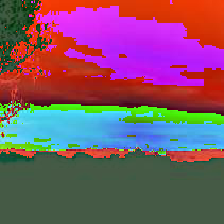

In [12]:
display(im)

## **RESNET**

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# create input with shape same as image shapes
image_input = Input(shape=(224, 224, 3))
# resnet model definiton with imagenet weights and output discarded
rn50_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)

94781440/94765736 [==============================] - 3s 0us/step


In [14]:
# layer freezing for not lose imagenet weights
for layer in rn50_model.layers:
  layer.trainable=False

In [15]:
# additional layers for resnet + custom combination
flat1 = Flatten()(rn50_model.layers[-1].output)
x = Dense(1256, activation='relu')(flat1)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
output = Dense(4, activation='softmax')(x)

In [16]:
# resnet50 + custom layers to create custom model
custom_model = Model(image_input, output)

In [17]:
custom_model.compile(loss = categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [18]:
import time

In [27]:
t=time.time()
#	t = now()
hist = custom_model.fit(X_train, y_train, batch_size=32, epochs=16, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Epoch 1/16
29/29 [==============================] - 10s 352ms/step - loss: 0.1541 - accuracy: 0.9678 - val_loss: 2.9796 - val_accuracy: 0.8230
Epoch 2/16
29/29 [==============================] - 10s 352ms/step - loss: 0.2888 - accuracy: 0.9689 - val_loss: 2.5098 - val_accuracy: 0.7212
Epoch 3/16
29/29 [==============================] - 10s 350ms/step - loss: 0.0981 - accuracy: 0.9833 - val_loss: 1.8045 - val_accuracy: 0.7965
Epoch 4/16
29/29 [==============================] - 10s 352ms/step - loss: 0.1728 - accuracy: 0.9756 - val_loss: 2.1204 - val_accuracy: 0.7611
Epoch 5/16
29/29 [==============================] - 10s 350ms/step - loss: 0.0915 - accuracy: 0.9833 - val_loss: 1.6505 - val_accuracy: 0.8097
Epoch 6/16
29/29 [==============================] - 10s 353ms/step - loss: 0.0407 - accuracy: 0.9911 - val_loss: 2.4238 - val_accuracy: 0.7965
Epoch 7/16
29/29 [==============================] - 11s 387ms/step - loss: 0.0794 - accuracy: 0.9900 - val_loss: 1.3351 - val_accuracy: 0.7655

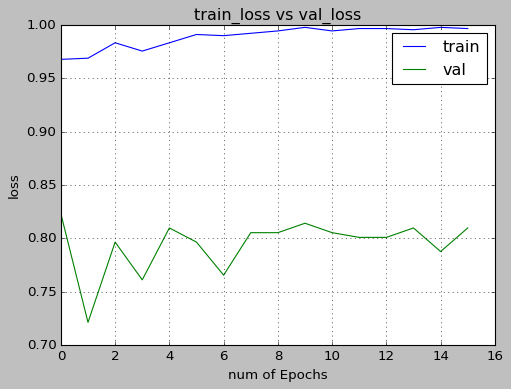

In [29]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy

def vis(hist):
  train_loss=hist.history['loss']
  val_loss=hist.history['val_loss']
  train_acc=hist.history['accuracy']
  val_acc=hist.history['val_accuracy']
  xc=range(16)

  plt.figure(1,figsize=(7,5))
  plt.plot(xc,train_acc)
  plt.plot(xc,val_acc)
  plt.xlabel('num of Epochs')
  plt.ylabel('loss')
  plt.title('train_loss vs val_loss')
  plt.grid(True)
  plt.legend(['train','val'])
  #print plt.style.available # use bmh, classic,ggplot for big pictures
  plt.style.use(['classic'])

vis(hist)

### **FINE TUNING**:

In [30]:
# checking layers 
for layer in custom_model.layers:
  print(layer.name)

print(len(custom_model.layers))

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [31]:
# we make specific layers trainable for tuning 
for layer in custom_model.layers[155:165]:
  layer.trainable = True

In [32]:
custom_model.compile(loss = categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [34]:
t=time.time()
#	t = now()
hist = custom_model.fit(X_train, y_train, batch_size=32, epochs=16, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Epoch 1/16
29/29 [==============================] - 10s 356ms/step - loss: 0.1066 - accuracy: 0.9822 - val_loss: 4.1029 - val_accuracy: 0.6947
Epoch 2/16
29/29 [==============================] - 10s 349ms/step - loss: 0.0700 - accuracy: 0.9867 - val_loss: 4.1548 - val_accuracy: 0.7301
Epoch 3/16
29/29 [==============================] - 10s 352ms/step - loss: 0.3245 - accuracy: 0.9822 - val_loss: 6.9261 - val_accuracy: 0.7434
Epoch 4/16
29/29 [==============================] - 10s 350ms/step - loss: 0.2282 - accuracy: 0.9867 - val_loss: 2.9924 - val_accuracy: 0.8186
Epoch 5/16
29/29 [==============================] - 10s 351ms/step - loss: 0.0647 - accuracy: 0.9878 - val_loss: 3.7106 - val_accuracy: 0.6814
Epoch 6/16
29/29 [==============================] - 10s 351ms/step - loss: 0.1485 - accuracy: 0.9778 - val_loss: 2.1509 - val_accuracy: 0.7965
Epoch 7/16
29/29 [==============================] - 10s 350ms/step - loss: 0.0186 - accuracy: 0.9900 - val_loss: 2.4771 - val_accuracy: 0.8053

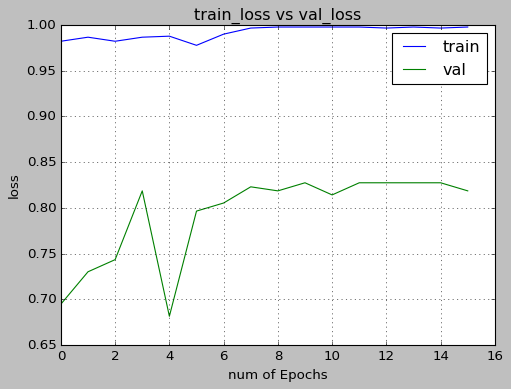

In [35]:
vis(hist)

## **INCEPTIONV3**

In [36]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [37]:
# create the base pre-trained model
image_input = Input(shape=(224, 224, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=image_input)

87924736/87910968 [==============================] - 1s 0us/step


In [38]:
# train only the top layers (which were randomly initialized)
# freeze all InceptionV3 layers
for layer in inception_model.layers:
    layer.trainable = False

In [39]:
# add a global spatial average pooling layer
x = inception_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# we have 4 classes
predictions = Dense(4, activation='softmax')(x)

# custom model = inceptionv3 + custom layers
custom_model2 = Model(inputs=inception_model.input, outputs=predictions)

In [40]:
# compiling the model with categorical crossentropy loss and adam optimizer
custom_model2.compile(loss = categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [44]:
t=time.time()
hist = custom_model2.fit(X_train, y_train, batch_size=32, epochs=16, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Epoch 1/16
29/29 [==============================] - 6s 210ms/step - loss: 0.8999 - accuracy: 0.8333 - val_loss: 5.6547 - val_accuracy: 0.4823
Epoch 2/16
29/29 [==============================] - 6s 209ms/step - loss: 1.3479 - accuracy: 0.8089 - val_loss: 3.2223 - val_accuracy: 0.6150
Epoch 3/16
29/29 [==============================] - 6s 212ms/step - loss: 0.9666 - accuracy: 0.8156 - val_loss: 3.3969 - val_accuracy: 0.6858
Epoch 4/16
29/29 [==============================] - 6s 208ms/step - loss: 0.7068 - accuracy: 0.8633 - val_loss: 4.6036 - val_accuracy: 0.5664
Epoch 5/16
29/29 [==============================] - 6s 209ms/step - loss: 2.1967 - accuracy: 0.7489 - val_loss: 3.0202 - val_accuracy: 0.6283
Epoch 6/16
29/29 [==============================] - 6s 207ms/step - loss: 1.3751 - accuracy: 0.7767 - val_loss: 7.0551 - val_accuracy: 0.6504
Epoch 7/16
29/29 [==============================] - 6s 208ms/step - loss: 4.0032 - accuracy: 0.7100 - val_loss: 4.8568 - val_accuracy: 0.5929
Epoch 

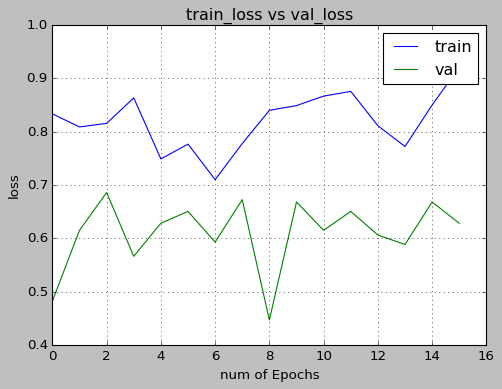

In [45]:
vis(hist)

# Fine Tuning for **InceptionV3**

In [46]:
for layer in custom_model2.layers:
  print(layer.name)

print(len(custom_model2.layers))

input_2
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [47]:
# we make specific layers trainable for tuning
for layer in custom_model2.layers[10:15]:
  layer.trainable=True

for layer in custom_model2.layers[160:165]:
  layer.trainable=True

for layer in custom_model2.layers[271:278]:
  layer.trainable=True

In [50]:
t=time.time()
hist = custom_model2.fit(X_train, y_train, batch_size=32, epochs=16, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Epoch 1/16
29/29 [==============================] - 6s 214ms/step - loss: 0.2471 - accuracy: 0.9133 - val_loss: 2.0286 - val_accuracy: 0.6681
Epoch 2/16
29/29 [==============================] - 6s 207ms/step - loss: 0.1922 - accuracy: 0.9300 - val_loss: 1.5890 - val_accuracy: 0.6814
Epoch 3/16
29/29 [==============================] - 6s 213ms/step - loss: 0.1065 - accuracy: 0.9611 - val_loss: 1.8483 - val_accuracy: 0.6814
Epoch 4/16
29/29 [==============================] - 6s 208ms/step - loss: 0.0870 - accuracy: 0.9689 - val_loss: 1.6516 - val_accuracy: 0.6681
Epoch 5/16
29/29 [==============================] - 6s 211ms/step - loss: 0.0717 - accuracy: 0.9733 - val_loss: 2.1154 - val_accuracy: 0.6195
Epoch 6/16
29/29 [==============================] - 6s 207ms/step - loss: 0.2290 - accuracy: 0.9289 - val_loss: 3.2584 - val_accuracy: 0.5221
Epoch 7/16
29/29 [==============================] - 6s 208ms/step - loss: 0.4655 - accuracy: 0.8678 - val_loss: 3.0723 - val_accuracy: 0.5575
Epoch 

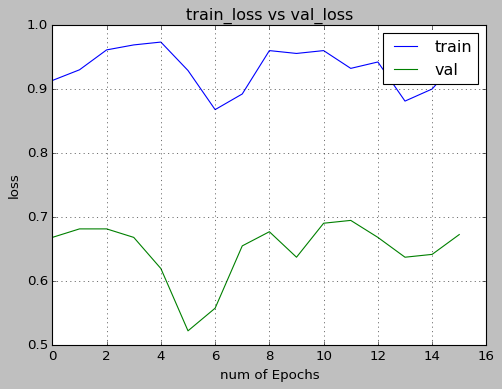

In [51]:
vis(hist)

### ÖMER KAAN VURAL